Description
======
This file aims to map two genome assemblies and find out how many gaps are filled in the new assembly compared to old assembly.
Since somes files are too large to upload in github, we have backed up them in google drive here. You can download it and then change the folder parameter to the path of it.
To run this code, you need to install MUMmer. And some python modules in the following cell.

In [8]:
%matplotlib inline  
from Bio import SeqIO
from pybedtools import BedTool
from collections import Counter
import sarge
import re
import multiprocessing as mp
from natsort import natsorted
import glob,os
import pandas as pd
import sarge,sys
import numpy as np
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The followings are parameters you need to define when running the code
--------------------------------------------------------------------------------

In [13]:
#================== Define some paramters
folder = '/data/shangzhong/Picr_assembly/fill_gap'  # path to the folder you downloaded from google drive
old_fa = folder + '/genomes/hamster.fa'
new_fa = folder + '/genomes/picr.fa'
new_gff = folder + '/genomes/picr_draft.gff3'#'/genomes/picr_maddy.gff'
chr_len_fn = folder + '/genomes/picr.fa.fai'
ref_super_pos_map = folder + '/genomes/picr_super_chr_pos.txt'
VCF_path = folder + '/VCF'
thread = 9

### 1. we align old genome to new genome using nucmer from MUMmer, since there is no parallel option in nucmer, we split the old genome into multiples files. Each file has one scaffold. After that results were merged into one file.

#### Some functions to run nucmer

In [5]:
#===============================================================================
#                     1. Compare old and new genome using MUMmer to find gap region in old genome
#===============================================================================
def split_fa(fa):
    # split fa file
    n = 0
    for record in SeqIO.parse(fa,'fasta'):
        fn = 'file'+str(n)+'.fa'
        with open(fn,'w') as f:
            SeqIO.write(record,f,'fasta')
        n += 1
        
def nucmer(ref,query):
    cmd = ('nucmer -maxmatch -p {pre} {r} {q}').format(pre=ref[:-3],r=ref,q=query) # -l 100 -c 200
    print(cmd)
    sarge.run(cmd)

def dnadiff(delta):
    cmd = ('dnadiff -d {delta}').format(delta=delta)
    print(cmd)
    sarge.run(cmd)

def main_nucmer(path,ref_fa,query_fa,thread):
    '''parallel nucmer and merge the results'''
    if not os.path.exists(path): os.mkdir(path)
    os.chdir(path)
    # 1. split fa file, each scaffold is in one fa file which prepares for parallelization
    split_fa(ref_fa)
    # 2. run nucmber
    faFiles = natsorted(glob.glob('file*.fa'))
    pool = mp.Pool(processes=int(thread))
    for f in faFiles:
        pool.apply_async(nucmer,args=(f,query_fa))
    pool.close()
    pool.join()
    # 3. merge delta files
    delta_fns = natsorted(glob.glob('file*.delta'))
    merge_fn = 'merge.delta'
    out_h = open(merge_fn,'w')
    out_h.write(''.join([ref_fa,' ',query_fa,'\n','NUCMER','\n']))
     
    for f in delta_fns:
        for i,line in enumerate(open(f)):
            if i > 1:
                out_h.write(line)
    out_h.close()
    # 4. clean files
    for f in glob.glob('file*.fa'):
        os.remove(f)
    for f in delta_fns:
        os.remove(f)
    # 5. run dna-diff
    dnadiff('merge.delta')  # generate out.1coords

#### run nucmer

In [6]:
#==================== 1. run nucmer
nucmer_dir = folder + '/nucmer'
if not os.path.exists(nucmer_dir):
    os.mkdir(nucmer_dir)
    os.chdir(nucmer_dir)
    main_nucmer(nucmer_dir,new_fa,old_fa,thread)

### 2. We extract gap regions in old genome and output into a file that has 4 columns: [scaffold name,gap start position, gap end position, length of gap]. Position is 0 based.

#### some functions to extract gap regions

In [93]:
#===============================================================================
#                     2. get start and end position of N in genome
#===============================================================================
def N_pattern(seq):
    '''This function search all Ns in seq, and return start and end position of them'''
    tuples = []
    while 'N' in seq:
        string = re.search('N{1,}',seq).group()
        start = seq.index(string)
        end = start + len(string)
        tuples.append((start,end))
        seq = seq.replace(seq[start:end],'.'*len(string),1)
    return tuples

def get_N_in_genome(fa,N_pos_file):
    '''This function gets start and end position of N that separate scaffolds in merged
    super scaffold 
    '''
    chrom = []
    chr_Npos = {}  # chrom: [(s1,e1),(s2,e2)]
    for record in SeqIO.parse(open(fa),'fasta'):
        seq = str(record.seq)
        if 'N' in seq:
            chrom.append(record.id)
            chr_Npos[record.id] = N_pattern(seq)
    handle = open(N_pos_file,'w')
    for key in chr_Npos:
        for t in chr_Npos[key]:
            handle.write('\t'.join([key,str(t[0]),str(t[1])])+'\n')
    handle.close()
    # add length column
    df = pd.read_csv(N_pos_file,sep='\t',names=['chr','start','end'])
    df['len'] = df['end']-df['start']
    df.to_csv(N_pos_file,sep='\t',index=False)
    return df

#### run code to get gap region in old genome

there are 97518 short gaps representing 58.6920410227  percent of total gaps
there are 521 short gaps representing 16.0951498301  percent of total gaps


IOError: [Errno 13] Permission denied: '/f02_gap_len_dist_new_genome.png'

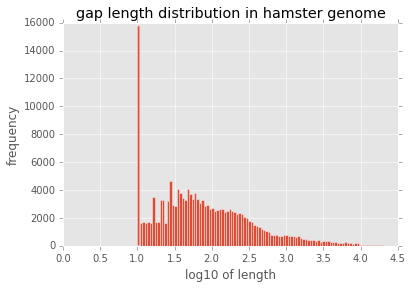

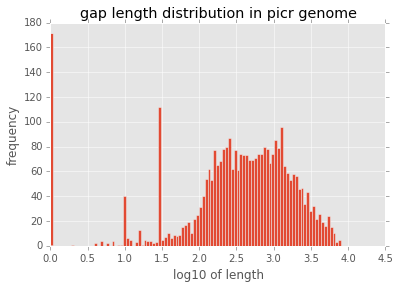

In [106]:
%%time
#==================== 2. get start and end position of N in old genome =======
# files
qry_N_pos_file = folder + '/01_old_N_pos.txt' 
ref_N_pos_file = folder + '/01_new_N_pos.txt'
# code
def plot_gap_len_dist(fa,pos_file,figure,title):
    if not os.path.exists(pos_file):
        ref_df = get_N_in_genome(fa,ref_N_pos_file)
        ref_df.head()
    if os.path.exists(pos_file):
        q_N_pos_df = pd.read_csv(pos_file,sep='\t',header=0)
        n = q_N_pos_df[q_N_pos_df['len'].values <= 90].shape[0]
        print 'there are',n,'short gaps','representing',float(n)/q_N_pos_df.shape[0]*100,' percent of total gaps'
        _ = plt.figure()
        ax = np.log10(q_N_pos_df['len']).plot(kind='hist',bins=100,title=title)
        _ = ax.set_xlabel('log10 of length')
        _ =ax.set_ylabel('frequency')
        _ =ax.set_xlim([0,4.5])
    plt.savefig(figure,dpi=600)
figure = folder + '/f01_gap_len_dist_old_genome.png'
title = 'gap length distribution in hamster genome'
plot_gap_len_dist(old_fa,qry_N_pos_file,figure,title)
figure = folder + '/f02_gap_len_dist_new_genome.png'
title = 'gap length distribution in picr genome'
plot_gap_len_dist(new_fa,ref_N_pos_file,figure,title)

### 3. After getting gap regions in old genome, we then try to find their corresponding regions in the new genome. Gap region doesn't map anywhere, but if the left and right fragments of gap maps to the new genome with simliar distance to gap lengh, then we are confident to determine the corresponding gap region in the new gennome. The all kinds of mapping situations around gap region is shown in the following figure.

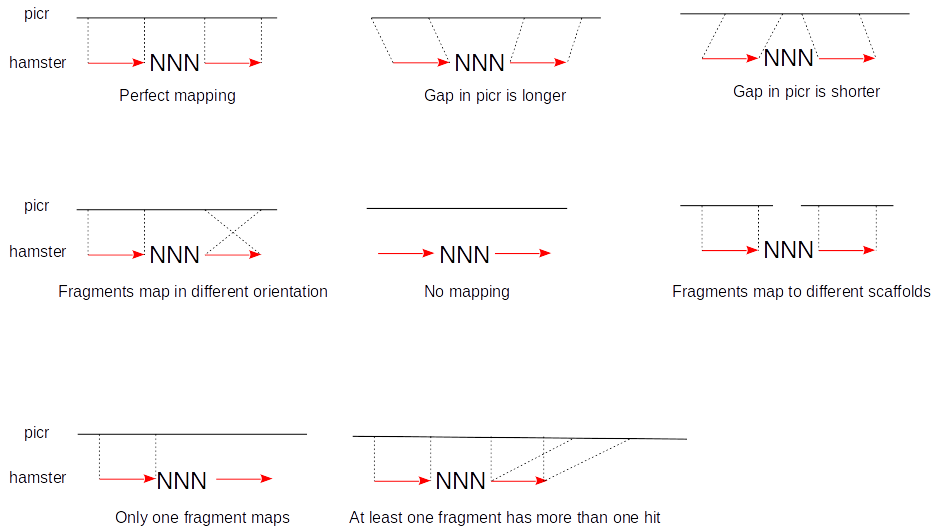

In [134]:
from IPython.core.display import Image
Image(filename = folder + "/gap_finding_strategy.png", width=600, height=500)

#### Functions to find corresponding regions of gap regions.

In [8]:
#===============================================================================
#                     3. get corresponding gap regions of old genome gaps
#===============================================================================
def get_gap_pos_in_ref(row,scaff_mcoord_df):
    '''get gap position mapping between old genome and new genome
    this function only process one line of the query gap.
    * scaff_mcoord_df: dataframe output from dnadiff. default file name is: out.1coords
    * row: row of the gap dataframe in the file 01_hamster_N_pos.txt.
    '''
    start = int(row['start'])
    end = int(row['end'])
    scaffold = row['chr']
    scaff_mcoord_df = scaff_mcoord_df.reset_index(drop=True)
    if scaff_mcoord_df.shape[0] == 0:
        return ['0']*4
    # add strand information and switch start and end for '-' strand
    scaff_mcoord_df['que_strand'] = scaff_mcoord_df.apply(lambda row: '+' if int(row['q_start']) < int(row['q_end']) else '-',axis=1)
    q_strand = list(set(scaff_mcoord_df['que_strand'].tolist()))
    if len(q_strand)>1:
        print  scaffold,'misassembly strand orientation inconsistent'
    pro_log = scaff_mcoord_df.apply(lambda r: abs(min(r['q_start'],r['q_end'])-1-end)<5,axis=1)  # first fragment mapping
    epi_log = scaff_mcoord_df.apply(lambda r: abs(max(r['q_start'],r['q_end'])-1-start)<5,axis=1)  # second fragment mapping
    if pro_log.tolist().count(True) == 2 or epi_log.tolist().count(True) == 2:
        return ['2']*3 + ['2_pro/epi map twice']
    cri = pro_log | epi_log 
    ref_gap_df = scaff_mcoord_df[cri]
    if ref_gap_df.shape[0] == 0:
        return ['0']*4   #'gap not found'
    elif ref_gap_df.shape[0] == 1:
        return ['1']*4   # 'one fragment map'
    elif ref_gap_df.shape[0] == 2:
        q_strand = list(set(ref_gap_df['que_strand'].tolist()))
        ref = list(set(ref_gap_df['ref'].tolist()))
        if len(ref) > 1:
            return ['2']*3+['2_double scaffold']
        else:
            ref = ref[0]
        if len(q_strand) == 2:
            return ['2']*3+['2_diff orientation']  #'fragments map to opsite strand'    # 1st type of output
        else:
            gap_pos = []
            for s,e in zip(ref_gap_df['r_start'],ref_gap_df['r_end']):
                gap_pos.extend([s,e])
            if gap_pos[0]<gap_pos[2]<gap_pos[1] or gap_pos[0]<gap_pos[3]<gap_pos[1]:
                return  ['2']*3+['2_overlap']#'fragments overlap'
            else:
                r_dist = abs(gap_pos[2]-gap_pos[1])
                q_dist = end - start 
                min_dist = min(r_dist,q_dist)
                if abs(r_dist-q_dist)/float(min_dist) > 0.5:
                    return [ref,str(min(gap_pos[1:3])-1),str(max(gap_pos[1:3])),'gap length is too different']
                else:
                    return [ref,str(min(gap_pos[1:3])-1),str(max(gap_pos[1:3])),'gap length is similar']
    elif ref_gap_df.shape[0] > 2:
        return ['3']*4 #'at least one fragment map to more than one place'

def get_df_gap_pos_in_ref(q_gap_df):
    '''this function gets gap positions in reference for all the gaps in query
    * q_gap_df: gap position. has 4 columns: ['chr','start','end','len']
    '''
    global out1coord_df
    scaff = q_gap_df['chr'].tolist()[0]
    scaff_map_df = out1coord_df[out1coord_df['query'].values==scaff]
    q_gap_df[['ref_chr','r_g_start','r_g_end','gap_type']] = q_gap_df.apply(lambda row: get_gap_pos_in_ref(row,scaff_map_df),axis=1)
    return q_gap_df

def applyParallel(dfGrouped,func,thread):
    retLst = Parallel(thread)(delayed(func)(group) for name,group in dfGrouped)
    return pd.concat(retLst)

#### find corresponding gap regions

In [9]:
out1coord = nucmer_dir + '/out.1coords'
gap_pos_fn = folder + '/03_gap_pos.txt'
if not os.path.exists(gap_pos_fn):
    # 1. read mummer coordinate file and hamster gap position file
    out1coord_df = pd.read_csv(out1coord,sep='\t',header=None,names=['r_start','r_end','q_start','q_end', 
                                     'r_m_len','q_m_len','m_perc','r_len','q_len','r_perc','q_perc','ref','query'])
    h_n_df = pd.read_csv(contig_N_pos_file,sep='\t',header=0,names=['chr','start','end','len'])
    # 2. get gap position
    gap_df = applyParallel(h_n_df.groupby(['chr']),get_df_gap_pos_in_ref,thread)
    gap_df['columns'] = ['qry','q_s','q_end','q_len','ref','r_s','r_e','gap_type']
    gap_df.to_csv(gap_pos_fn,sep='\t',index=False)

### 4. When MUMmer aligns the genome, if two mapping fragments are less than 90 bps, it merge them into one large fragment. Thus the gap regions would be considered as mapping and the previous method cannot find the corresponding gaps. Therefore we parse the alignment file to extract these small gap regions.

### functions to find corresponding small gap regions

In [39]:
#===============================================================================
#                     4. get corresponding gap position of short (<90) hamster gaps
#===============================================================================
def get_ref_gap(ali_fn,map_line):
    '''this function gets corresponding reference gap region given the query gap region and mapping between query and reference
    * ali_fn: mapping results of a query to reference using show-align function of mummer
    * map_line: a row results from getting overlap between query gap region and mapping results
                example line: NW_006868509.1 11915 11973 58 NW_006868509.1 6413 16359 9947 picr_40 458738 468713 9976 58
    '''
    item = map_line#.split('\t')
    que = item[0]
    gap_s = int(item[1])
    gap_e = int(item[2])
    p_ali_fn = '/'.join(ali_fn.split('/')[:-1]) + '/' + que + '_' + str(item[1])
    # extract the pairwise mapping
    cmd = ('sed -n \'/{start}/,/{start}/p\' {in_fn} > {out}').format(start=str(item[9])+' - '+str(item[10]),in_fn=ali_fn,out=p_ali_fn)
    sarge.run(cmd)
    with open(p_ali_fn) as f:
        n = 0
        q_pos = []
        r_pos = []
        for line in f:
            if line.startswith('\n') or line.startswith(' '):
                continue
            elif line.startswith('-'):
                if '| +1' in line:
                    step = 1
                else:
                    step = -1
                continue
            else:
                n += 1
                if n%2 == 1:
                    l = line.strip().split()
                    r_seq = l[1]
                    r_s = int(l[0])
#                     r_e = r_s + len(l[1]) - l[1].count('.')
                if n%2 == 0:
                    l = line.strip().split()
                    q_seq = l[1]
                    q_s = int(l[0])
                    q_e = q_s + len(l[1])*step - l[1].count('.')
                    # start to test the pos
                    max_q = max(q_s,q_e)
                    min_q = min(q_s,q_e)
                    if min_q<=gap_s+1<=max_q or min_q<=gap_e<=max_q or gap_s+1<=q_s<=gap_e: # item[1] is query start position of the gap
                        q_pos.append(q_s-step)
                        r_pos.append(r_s-1)
                        for r,q in zip(r_seq,q_seq):
                            if r=='.':
                                r_pos.append(r_pos[-1])
                            else:
                                r_pos.append(r_pos[-1]+1)
                            if q=='.':
                                q_pos.append(q_pos[-1])
                            else:
                                q_pos.append(q_pos[-1]+step)
                    if (gap_e < q_s and step==1) or (gap_s>q_s and step==-1):  # out of the gap region, no need to go over the following lines
                        break
        q_pos = q_pos[1:]
        r_pos = r_pos[1:]
        s_index = q_pos.index(gap_s+1)
        e_index = q_pos.index(gap_e)
        if step == 1:
            ref_s = r_pos[s_index]
            ref_e = r_pos[e_index]
        else:
            ref_s = r_pos[e_index]
            ref_e = r_pos[s_index]
        min_index = min(s_index,e_index)
        if r_pos[min_index] == r_pos[min_index+1] and ref_s < ref_e:
            ref_s += 1
    os.remove(p_ali_fn)
    return ref_s,ref_e

def applyParallel(dfGrouped,func,thread):
    retLst = Parallel(thread)(delayed(func)(group) for name,group in dfGrouped)
    return pd.concat(retLst)

def wrap_get_ref_gap4_scaffold(qry_ref_df):
    '''this is a wrap of get_ref_gap
    * qry_ref_df: dataframe of mapping between gap region and mummy alignment
            example row is: NW_006868509.1 11915 11973 58 NW_006868509.1 6413 16359 9947 picr_40 458738 468713 9976 58
    '''
    global delta
    ref = list(qry_ref_df[8])[0]
    qry = list(qry_ref_df[0])[0]
    q_ref_map_fn = '/'.join(delta.split('/')[:-1]) + '/' + ref+'_'+qry
    cmd = ('show-aligns -r {delta} {ref_id} {qry_id} > {out}').format(delta=delta,ref_id=ref,qry_id=qry,out=q_ref_map_fn)
    sarge.run(cmd)
    qry_ref_df['r_s'],qry_ref_df['r_e'] = zip(*qry_ref_df.apply(lambda row:get_ref_gap(q_ref_map_fn,row),axis=1))
    os.remove(q_ref_map_fn)
    return qry_ref_df

#### find corresponding short gap regions
* Since the short gap regions are inside the mapping regions, the workflow is: get intersection between gap region and mapping region in old genome ---> get the mapping region in the new genome ---> parse alignment to find exact region in the new genome that matches the gap region in old genome.
* 1. get overlap

In [38]:
# 1. read the file generated by dnadiff which is 1-to-1 coordinates mapping
out1coord = nucmer_dir + '/out.1coords'
out1coord_df = pd.read_csv(out1coord,sep='\t',header=None,names=['r_start','r_end','q_start','q_end', 
                                     'r_m_len','q_m_len','m_perc','r_len','q_len','r_perc','q_perc','ref','query'])

out1coord_df['start'] = out1coord_df.apply(lambda row: min(int(row['q_start']),int(row['q_end']))-1,axis=1)
out1coord_df['end'] = out1coord_df.apply(lambda row: max(int(row['q_start']),int(row['q_end'])),axis=1)
# 2. get overlap between out.1coords and the gap region in 03_gap_pos.txt
bed_cord = BedTool.from_dataframe(out1coord_df[['query','start','end','q_m_len','ref','r_start','r_end','r_m_len']])
gap_03_df = pd.read_csv(gap_pos_fn,sep='\t',header=0)
gap_03_df = gap_03_df[gap_03_df['q_len'].values <= 90]
print gap_03_df.shape
gap_03_df = gap_03_df[gap_03_df['ref'].isin(['0','1','2','3'])]
print gap_03_df.shape
bed_gap = BedTool.from_dataframe(gap_03_df[['qry','q_s','q_e','q_len']])
inter = bed_gap.intersect(bed_cord,f=1,wo=True)
qry_ref_gap_df = inter.to_dataframe()
print 'column 0-2 are short gap regions in old genome, 4-6, 8-10 are mappings between old and new genome, 3,7,11 are length, 12 is overlap length between 0-2 and 4-6'
display(qry_ref_gap_df)

(97518, 8)
(92828, 8)
column 0-2 are short gap regions in old genome, 4-6, 8-10 are mappings between old and new genome, 3,7,11 are length, 12 is overlap length between 0-2 and 4-6


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NW_006868509.1,23749,23782,33,NW_006868509.1,19661,30929,11268,picr_40,472619,483852,11234,33
1,NW_006868509.1,43935,43953,18,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,18
2,NW_006868509.1,50640,50663,23,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,23
3,NW_006868509.1,65594,65604,10,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,10
4,NW_006868509.1,68571,68655,84,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,84
5,NW_006868509.1,118399,118468,69,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,69
6,NW_006868509.1,119681,119706,25,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,25
7,NW_006868509.1,133164,133174,10,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,10
8,NW_006868509.1,167213,167226,13,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,13
9,NW_006868509.1,184672,184723,51,NW_006868509.1,172512,219555,47043,picr_40,627243,674206,46964,51


* 2. Add region that matches the short gap region in the old genome

In [40]:
# 3. get corresponding short gap region in ref
delta = nucmer_dir + '/merge.delta'
os.chdir(folder)
short_gap_pos_fn = folder+'/04_short_gap_in_ref.txt'
if not os.path.exists(folder)
    gap_df = applyParallel(qry_ref_gap_df.groupby([0,8]),wrap_get_ref_gap4_scaffold,thread)
    res_df = gap_df.rename(columns={0:'qry',1:'q_s',2:'q_e',8:'ref'})
    res_df[['qry','q_s','q_e','ref','r_s','r_e']].to_csv(short_gap_pos_fn,sep='\t',index=False)
    res_df

,qry,q_s,q_e,3,4,5,6,7,ref,9,10,11,12,r_s,r_e
0,NW_006868509.1,23749,23782,33,NW_006868509.1,19661,30929,11268,picr_40,472619,483852,11234,33,476707,476727
1,NW_006868509.1,43935,43953,18,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,18,497844,497848
2,NW_006868509.1,50640,50663,23,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,23,504543,504554
3,NW_006868509.1,65594,65604,10,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,10,519460,519469
4,NW_006868509.1,68571,68655,84,NW_006868509.1,38044,79376,41332,picr_40,491927,533217,41291,84,522436,522499
5,NW_006868509.1,118399,118468,69,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,69,573226,573277
6,NW_006868509.1,119681,119706,25,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,25,574464,574475
7,NW_006868509.1,133164,133174,10,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,10,587961,587970
8,NW_006868509.1,167213,167226,13,NW_006868509.1,105274,172282,67008,picr_40,560156,627055,66900,13,622031,622033
9,NW_006868509.1,184672,184723,51,NW_006868509.1,172512,219555,47043,picr_40,627243,674206,46964,51,639452,639457


### 5. Since the new genome still has too many scaffolds, which would lead to very slow variant calling. We merged the scaffolds into a few super long scaffolds with each original scaffold separated by 500 letter N. So we need to do one more step to transfer gap region in reference genome to region in super scaffold genome.

In [5]:
def ref_gap2super_gap(row,ref_super_dic):
    '''this function change reference gap position to super scaffold gap position and add super scaffold name
    * row: one row in dataframe from file 03_gap_pos.txt
    * ref_super_dic: {picr chromosome: super picr chromosome}
    '''
    ref_chr = row['ref']
    item = ref_super_dic[ref_chr]
    start = int(item[1]) + int(row['r_s'])
    end = int(item[1]) + int(row['r_e'])
    return [item[0],str(start),str(end)]

def qry_super_gap(gap_pos_fn,short_gap_pos_fn,ref_super_pos_map):
    # 1. build ref super_ref map
    ref_super_dic = {}
    for line in open(ref_super_pos_map):
        item = line.strip().split('\t')
        ref_super_dic[item[3]] = item[:2]
    # 1. merge long and short gap
    long_gap_df = pd.read_csv(gap_pos_fn,sep='\t',header=0)
    long_gap_df = long_gap_df[~long_gap_df['ref'].isin(['0','1','2','3'])][['qry','q_s','q_e','ref','r_s','r_e','gap_type']]
    short_gap_df = pd.read_csv(short_gap_pos_fn,sep='\t',header=0)
    short_gap_df['gap_type'] = pd.Series(['short']*(short_gap_df.shape[0]))
    gap_df = long_gap_df.append(short_gap_df)
    gap_df = gap_df.reset_index(drop=True)

    gap_df[['super_chr','super_start','super_end']] = gap_df.apply(lambda row: pd.Series(ref_gap2super_gap(row,ref_super_dic)),axis=1)
    return gap_df

merge_gap_fn = folder+'/05_all_gap.txt'
if not os.path.exists(merge_gap_fn):
    gap_df = qry_super_gap(gap_pos_fn,short_gap_pos_fn,ref_super_pos_map)
    gap_df.to_csv(merge_gap_fn,sep='\t',index=False)
    display(gap_df)

#### Some statistics on the gap regions in the new genome
* 1. get how many gaps are there for each scaffold, plot gap number VS scaffold length.
* 2. get total gap length of each scaffold, plot gap length VS scaffold length

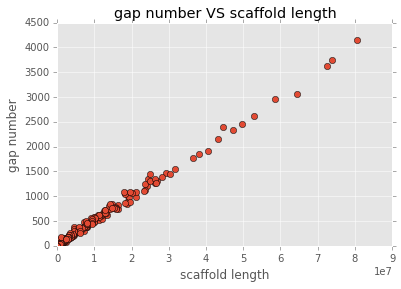

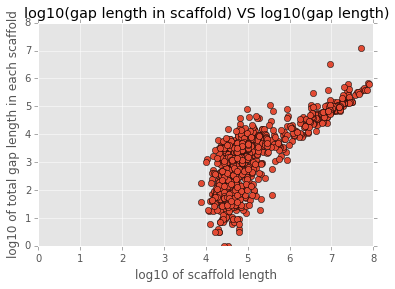

In [91]:
merge_gap_fn = folder + '/05_all_gap.txt'
if os.path.exists(merge_gap_fn):
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    # gap number vs scaffold length
    gap_num_df = pd.DataFrame(Counter(gap_df['ref']).items(),columns=['chr','num'])
    chr_len_df = pd.read_csv(chr_len_fn,sep='\t',header=None,usecols=[0,1],names=['chr','len'])
    num_len_df = pd.merge(gap_num_df,chr_len_df,on='chr',how='inner')
    _ = plt.figure()
    _ = plt.plot(num_len_df['len'],num_len_df['num'],'o')
    _ = plt.title('gap number VS scaffold length')
    _ = plt.xlabel('scaffold length')
    _ = plt.ylabel('gap number')
    plt.savefig(folder+'/gap_num_VS_scaf_len.png',dpi=600)
    # gap length vs scaffold length
#     gap_df['ref_glen'] = gap_df['r_e'] - gap_df['r_s']
#     ref_gap_len_df = gap_df[['ref','ref_glen']].groupby('ref').sum()
#     ref_gap_len_df['chr'] = ref_gap_len_df.index
# #     len_len_df = pd.merge(ref_gap_len_df,chr_len_df,on='chr',how='inner')

    gap_len_dic = {}
    for c,s,e in zip(gap_df['ref'],gap_df['r_s'],gap_df['r_e']):
        if c in gap_len_dic:
            gap_len_dic[c] |= set(range(int(s)+1,int(e)+1))
        else:
            gap_len_dic[c] = set()
    for key in gap_len_dic:
        gap_len_dic[key] = len(gap_len_dic[key])
    gap_len_dic2df = pd.DataFrame(gap_len_dic.items())
    gap_len_dic2df.columns=['chr','ref_glen']
    len_len_df = pd.merge(gap_len_dic2df,chr_len_df,on='chr',how='inner')
    _ = plt.figure()
    _ = plt.plot(np.log10(len_len_df['len']),np.log10(len_len_df['ref_glen']),'o')
    _ = plt.title('log10(gap length in scaffold) VS log10(gap length)')
    _ = plt.xlabel('log10 of scaffold length')
    _ = plt.ylabel('log10 of total gap length in each scaffold')
    _ = plt.xlim([0,8])
    plt.savefig(folder+'/gap_len_VS_scaf_len.png',dpi=600)
    plt.show()

### 6. After getting the gap regions, next is to process the vcf files. We need to get variants that are only in target samples, not in controls, and then extract variants in the gap region. For reference, snp and insertion both can be represented by one position, but deletion need to be represened using a region. So we change all varaints into a region and then get intersection with gap region.
* 1. filter out variants in variants

In [48]:
ctrl_vcf =  VCF_path + '/control_vcf/hamsterDNA2newAssembly.merged.filter.vcf'
#===============================================================================
#                     4. filter variants using control gene variant statistics
#===============================================================================
def vari_type(row):
    '''decide variation type for function get_vcf_num_in_gap'''
    if len(row['REF']) == len(row['ALT']):
        return 'snp'
    elif len(row['REF']) > len(row['ALT']):
        return 'del'
    elif len(row['REF']) < len(row['ALT']):
        return 'ins'
    
def vcf_stats(vcf):
    dic = {'snp':0,'ins':0,'del':0}
    for line in open(vcf):
        if line.startswith('#'):
            continue
        else:
            item = line.strip().split('\t')
            if len(item[3]) == len(item[4]):
                dic['snp'] += 1
            elif len(item[3]) > len(item[4]):
                dic['del'] += 1
            elif len(item[3]) < len(item[4]):
                dic['ins'] += 1
    return dic

def remove_control_vcf(vcf,control,out_pre):
    '''remove the control variants in the sample varaints
    * vcf: target vcf results
    * control: vcf results called using its own DNAseq
    '''
    cmd = ('vcftools --vcf {vcf} --diff {control} --out {pre}').format(vcf=vcf,control=control,pre=out_pre)
#     print(cmd);sys.stdout.flush()
    sarge.run(cmd)

def get_vcf_in_gap(merge_gap_fn,diff_vcf,vcf_in_gap_fn):
    '''get variants in gap region
    * merge_gap_fn: has all gaps in qry ref and super ref
    * diff_vcf: varaint file only in qry
    * vcf_in_gap_fn: output store gap and varaints
    '''
    gap_df = pd.read_csv(merge_gap_fn,sep='\t',header=0)
    gap_df = gap_df[gap_df['super_start']<gap_df['super_end']]
    columns = ['super_chr','super_start','super_end',\
                    'qry','q_s','q_e','ref','r_s','r_e','gap_type']
    gap_bed = BedTool.from_dataframe(gap_df[columns])
    diff_vcf_df = pd.read_csv(diff_vcf,sep='\t',usecols=[0,1,3,4,6],names=['ref','POS','file','REF','ALT'])
    qry_vcf_df = diff_vcf_df[diff_vcf_df['file'].values == '1']
    qry_vcf_df = qry_vcf_df.reset_index(drop=True)
    qry_vcf_df['vcf_type'] = qry_vcf_df[['REF','ALT']].apply(lambda row: vari_type(row),axis=1)
    qry_vcf_df['v_s'] = qry_vcf_df['POS'].astype('int')-1
    qry_vcf_df['v_e'] = qry_vcf_df[['v_s','REF','vcf_type']].apply(lambda row:int(row['v_s'])+len(row['REF']) \
                                                if row['vcf_type']=='del' else int(row['v_s'])+1,axis=1)
    # get intersection
    vcf_bed = BedTool.from_dataframe(qry_vcf_df[['ref','v_s','v_e','vcf_type']])
    inter_bed = vcf_bed.intersect(gap_bed,wo=True)
    columns = ['vcf_ref','vcf_start','vcf_end','vcf_type','gap_ref','gap_start','gap_end',\
                        'qry','q_s','q_e','ref','ref_s','ref_e','gap_type','len']
    inter_df = inter_bed.to_dataframe(names=columns)
    inter_df.to_csv(vcf_in_gap_fn,sep='\t',index=False)
    return inter_df

* 1. Get variants in gap regions.  2. then get variants in cds regions.

In [27]:
test_vcf_paths = [p for p in natsorted(glob.glob(VCF_path+'/test_vcf/*')) if os.path.isdir(p)]
for test_path in test_vcf_paths:
    vcf = glob.glob(test_path + '/*.vcf')[0]
    out_pre = test_path + '/' + vcf.split('/')[-1].split('.')[0]
    # filter out control vcfs
    diff_vcf = out_pre + '.diff.sites_in_files'
    if not os.path.exists(diff_vcf):
        remove_control_vcf(vcf,ctrl_vcf,out_pre)
    # get varaints in gap regions
    vcf_in_gap_fn = out_pre+'_vcf_in_gap.txt'
    if not os.path.exists(vcf_in_gap_fn):
        inter_df = get_vcf_in_gap(merge_gap_fn,diff_vcf,vcf_in_gap_fn)
    # get gap variants in cds region
    vcf_in_cds_fn = out_pre+'_vcf_in_cds_gff.txt'
    if not os.path.exists(vcf_in_cds_fn):
        gap_vcf_df = pd.read_csv(vcf_in_gap_fn,sep='\t',header=0,low_memory=False)
        gap_vcf_bed = BedTool.from_dataframe(gap_vcf_df[['vcf_ref','vcf_start','vcf_end','vcf_type']])
        gff_df = pd.read_csv(new_gff,sep='\t',header=None,comment='#',names=['ref','s','f','r_s','r_e','q','str','n2','anno'])
        cds_df = gff_df[gff_df['f'].values=='CDS']
        cds_df = cds_df.reset_index(drop=True)
        # define new genome to super genome dictionary
        ref_super_dic = {}
        for line in open(ref_super_pos_map):
            item = line.strip().split('\t')
            ref_super_dic[item[3]] = item[:2]
        cds_df[['super_chr','super_start','super_end']] = cds_df.apply(lambda row: pd.Series(ref_gap2super_gap(row,ref_super_dic)),axis=1)
        cds_bed = BedTool.from_dataframe(cds_df[['super_chr','super_start','super_end','anno']])
        cds_vcf_df = (gap_vcf_bed.intersect(cds_bed,wo=True)).to_dataframe()
        cds_vcf_df.columns = ['v_ref','v_s','v_e','vcf_type','cds_ref','cds_s','cds_e','anno','len']
        cds_vcf_df.to_csv(vcf_in_cds_fn,sep='\t',index=False)

#### Next we will get statistics of variants

In [72]:
%%time
test_vcf_paths = [p for p in natsorted(glob.glob(VCF_path+'/test_vcf/*')) if os.path.isdir(p)]
stat_df = pd.DataFrame()
for test_path in test_vcf_paths:
    stat = []
    # total number of variants, control number and filterred number
    diff_vcf = glob.glob(test_path+'/*.diff.sites_in_files')[0]
    vcf_in_gap_fn = glob.glob(test_path+'/*_vcf_in_gap.txt')[0]
    vcf_in_cds_fn = glob.glob(test_path+'/*_in_cds_new_gff.txt')[0]
    if os.path.exists(vcf_in_gap_fn) and os.path.exists(diff_vcf):
        diff_vcf_df = pd.read_csv(diff_vcf,sep='\t',header=0,usecols=[0,3,4,6],names=['CHROM','IN_FILE','REF','ALT'])
        ctrl_vcf_df = diff_vcf_df[diff_vcf_df['IN_FILE'].isin(['B'])]
        filt_vcf_df = diff_vcf_df[diff_vcf_df['IN_FILE'].isin(['1'])]
        total = ctrl_vcf_df.shape[0] + filt_vcf_df.shape[0]
        stat.extend([total,ctrl_vcf_df.shape[0],filt_vcf_df.shape[0]])
        # snp, indel number after filter
        filt_vari_c = {'snp':0,'ins':0,'del':0}
        for ref,alt in zip(filt_vcf_df['REF'],filt_vcf_df['ALT']):
            if len(ref) == len(alt):
                filt_vari_c['snp'] += 1
            elif len(ref) > len(alt):
                filt_vari_c['del'] += 1
            elif len(ref) < len(alt):
                filt_vari_c['ins'] += 1
        stat.extend([filt_vari_c['snp'],filt_vari_c['ins'],filt_vari_c['del']])
        # snp, indel in gap region
        vcf_in_gap_df = pd.read_csv(vcf_in_gap_fn,sep='\t',header=0,usecols=[0,1,2,3])
        vcf_gap_dic = Counter((vcf_in_gap_df.drop_duplicates())['vcf_type'])
        stat.extend([vcf_gap_dic['snp'],vcf_gap_dic['ins'],vcf_gap_dic['del']])
        # snp, indel in cds region
        vcf_in_cds_df = pd.read_csv(vcf_in_cds_fn,sep='\t',header=0,usecols=[0,1,2,3])
        vcf_cds_dic = Counter(vcf_in_cds_df.drop_duplicates()['vcf_type'])
        stat.extend([vcf_cds_dic['snp'],vcf_cds_dic['ins'],vcf_cds_dic['del']])
        stat_df[test_path.split('/')[-1]] = pd.Series(stat)
stat_df.index=['total_var','control_var','filter_var','filter_snp','filter_ins','filter_del',
              'gap_snp','gap_ins','gap_del','cds_snp','cds_ins','cds_del']
display(stat_df)

,1D9_2picr_DNA,1D9_3mon2picr_DNA,FCS2picr_DNA,K1_6mon2picr_DNA,MCB2picr,no_gln2picr_DNA
total_var,5901401,5894448,5948137,5548170,5813705,5833668
control_var,1133805,1138751,1122569,993010,1072086,1061842
filter_var,4767596,4755697,4825568,4555160,4741619,4771826
filter_snp,3727231,3725799,3849415,3612053,3758389,3781099
filter_ins,518096,511587,481742,467250,480580,491032
filter_del,522269,518311,494411,475857,502650,499695
gap_snp,52184,51301,51368,45234,45621,51028
gap_ins,7863,7259,6601,5890,7104,7068
gap_del,7727,7521,6671,6168,7034,7038
cds_snp,906,906,951,889,813,878


CPU times: user 39.6 s, sys: 6.46 s, total: 46.1 s
Wall time: 48 s


In [77]:
stat_df.to_csv(folder+'/vcf_stat.txt',sep='\t')